**Importation des données** <br/> données de https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/dataset_P4.zip

In [1]:
#importation des librairies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import datetime as dt
import statistics as st
import math
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency, f_oneway

In [2]:
#importation des données dans des dataframes
trades_cl = pd.read_csv("trades_clean.csv")
clients = pd.read_csv("dataset_P4/customers.csv")
products = pd.read_csv("dataset_P4/products.csv")
transactions = pd.read_csv("dataset_P4/transactions.csv")

## Analyse de données

In [3]:
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


<function matplotlib.pyplot.show(*args, **kw)>

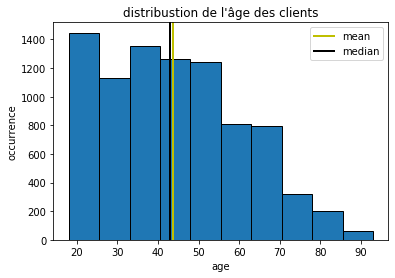

In [4]:
clients['age'] = 2022 - clients['birth']
plt.hist(clients.age, edgecolor='k')
plt.title("distribustion de l'âge des clients")
plt.ylabel('occurrence')
plt.xlabel('age')
plt.axvline(x=clients.age.mean(), label='mean', linewidth=2, color = 'y')
plt.axvline(x=st.median(clients.age), label='median', linewidth=2, color = 'black')
#plt.savefig("hist_age.png")
plt.legend()
plt.show

In [5]:
clients.age.skew(), clients.age.mean(), st.mode(clients.age), st.median(clients.age)

(0.36100192847210094, 43.71912327496231, 18, 43)

In [6]:
print(f"la distribution de l'âge des clients est proche de  0 (0< {clients.age.skew():0.2} <0.5) et positive \
\nOn observe qu'elle a une queue vers la droite et mode < median < mean\
\net donc on a plus d'individus vers la gauche par rapport à la moyenne")

la distribution de l'âge des clients est proche de  0 (0< 0.36 <0.5) et positive 
On observe qu'elle a une queue vers la droite et mode < median < mean
et donc on a plus d'individus vers la gauche par rapport à la moyenne


In [7]:
clients.groupby('age').count().mean()['client_id']

113.46052631578948

In [8]:
clients.groupby('age').count().sort_values('client_id', ascending=False)['client_id'][:5]

age
18    440
43    215
34    207
36    203
44    199
Name: client_id, dtype: int64

#### **On observe 440 individus dans la catégorie clients qui ont 18 ans >> ~113 individus par catégorie en moyenne**. 

In [9]:
clients['age'].describe()

count    8623.000000
mean       43.719123
std        16.919535
min        18.000000
25%        30.000000
50%        43.000000
75%        56.000000
max        93.000000
Name: age, dtype: float64

In [10]:
clients['age_categ'] = pd.cut(clients['age'], bins=[0, 25, 60, float('Inf')], labels=['<=25', '25-60', '>60'])

In [11]:
clients_df = clients.groupby( by = 'age_categ').agg({'client_id':'count'})
clients_df

,client_id
age_categ,
<=25,1447
25-60,5620
>60,1556


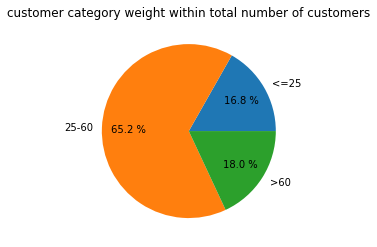

In [12]:
#part des classes d'age de clients
labl = clients_df.index.unique() 
plt.pie(clients_df.client_id, labels = labl, autopct = '%.1f %%', pctdistance = 0.7)
plt.title('customer category weight within total number of customers')
#plt.savefig("age_of_customers.png")
plt.show()

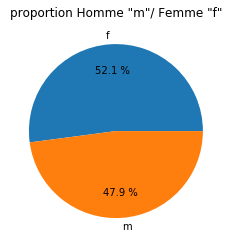

In [13]:
#proportion Homme / Femme dans l'échantillon : légère majorité de Femmes
la = clients.sex.unique()
plt.pie(clients.groupby('sex').count()['client_id'], labels = la, autopct = '%.1f %%', pctdistance = 0.7)
plt.title('proportion Homme "m"/ Femme "f"')
#plt.savefig("male_female_ratio.png")
plt.show()

In [14]:
# on drop le produit 'T_0'
products.drop(products[products['id_prod'] == 'T_0' ].index, inplace = True)

In [15]:
#prix moyen par catégorie : on RQ que la catégorie a une moyenne élevée pour des livres
products.groupby('categ').mean()

,price
categ,
0,11.732795
1,25.531421
2,108.354686


In [16]:
products.groupby('categ').count()

,id_prod,price
categ,,
0,2308,2308
1,739,739
2,239,239


<function matplotlib.pyplot.show(*args, **kw)>

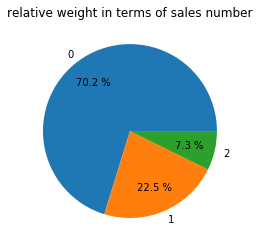

In [17]:
lab = products.categ.unique()
plt.pie(products.groupby('categ').count()['id_prod'], labels = lab, autopct = '%.1f %%', pctdistance = 0.7)
plt.title('relative weight in terms of sales number')
#plt.savefig("category_weight_count.png")
plt.show

In [18]:
# ventes totales par catégories
products.groupby('categ').sum()

,price
categ,
0,27079.29
1,18867.72
2,25896.77


<function matplotlib.pyplot.show(*args, **kw)>

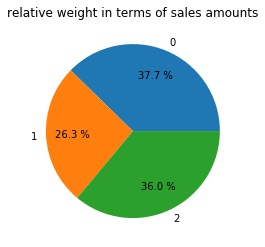

In [19]:
#part des categories de produits dans les ventes totales
labe = products.categ.unique()
plt.pie(products.groupby('categ').sum()['price'], labels = labe, autopct = '%.1f %%', pctdistance = 0.7)
plt.title('relative weight in terms of sales amounts')
#plt.savefig("categ_weight_sales.png")
plt.show

### On a identifié des données manquantes en Octobre peut être à cause d'un problème d'intégration dans la base de données ou bien de collecte, mais on choisit de conserver les données partielles d'Octobre pour un certain nombre d'analyses car les données sont précieuses

In [20]:
#Le split en 2 script pose des problèmes lorsqu'on ré_importe le csv nettoyé, on les corrige
trades_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  336816 non-null  int64  
 1   id_prod     336816 non-null  object 
 2   date        336816 non-null  object 
 3   session_id  336816 non-null  object 
 4   client_id   336816 non-null  object 
 5   time        336816 non-null  object 
 6   year        336816 non-null  int64  
 7   month       336816 non-null  int64  
 8   hour        336816 non-null  int64  
 9   price       336816 non-null  float64
 10  categ       336816 non-null  float64
 11  categ_2     336816 non-null  int64  
 12  sex         336816 non-null  object 
 13  birth       336816 non-null  int64  
 14  age         336816 non-null  int64  
 15  age_categ   336816 non-null  object 
dtypes: float64(2), int64(7), object(7)
memory usage: 41.1+ MB


## On retravaille le csv nettoyé car des problèmes apparaissent

In [21]:
trades_cl.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [22]:
trades_cl['date'] = pd.to_datetime(trades_cl['date'], 
                                        format='%Y-%m-%d',
                                     infer_datetime_format=True, 
                                     errors='coerce')

In [23]:
#test
trades_cl.loc[trades_cl['age'].isnull() | trades_cl['price'].isnull()]

,id_prod,date,session_id,client_id,time,year,month,hour,price,categ,categ_2,sex,birth,age,age_categ


### analyse temporelle : CA (hypothèse les ventes totales reflètent le CA)

In [24]:
#on aggrège en utilisant un dictionnaire
year_df = trades_cl.groupby( by = ['year', 'month']).agg({'price':['sum', 'count']})
year_df.head(20)

price       
                      sum  count
year month                      
2021 3      479417.625152  28568
     4      473144.979125  28415
     5      489461.812357  28245
     6      481340.069562  26819
     7      480945.591178  24716
     8      479410.785152  25619
     9      502912.073535  33266
     10     319242.089562  21584
     11     513007.497946  28277
     12     523019.809562  32424
2022 1      523013.973973  29316
     2      532869.940741  29567

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

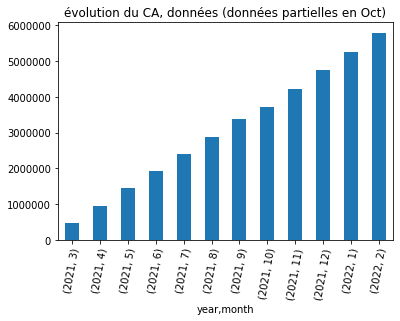

In [25]:
# analyse CA
year_df2 = trades_cl.groupby( by = ['year', 'month']).agg({'price':'sum'})
year_df2['ca'] = np.cumsum(year_df2.price)
year_df2['ca'].plot(kind = 'bar')
plt.title('évolution du CA, données (données partielles en Oct)')
#plt.savefig("ev_CA.png")
plt.xticks(rotation=80)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

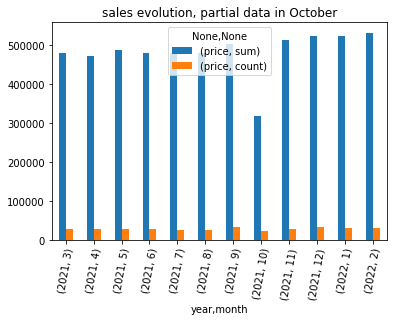

In [26]:
# la somme de toutes les ventes reflète le CA, d'o`u : 
year_df.plot(kind = 'bar')
plt.title("sales evolution, partial data in October")
#year_df2[['ca']]#['ca'].plot(kind = 'bar')
plt.xticks(rotation=80)

In [27]:
#A quelle heure de la journée le libraire fait-il plus de ventes?
hours = [ hour for hour, df in trades_cl.groupby('hour')]

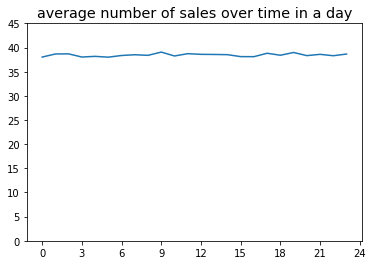

In [28]:
plt.plot(hours, trades_cl.groupby('hour').agg({'price':'count'})/365)
plt.style.use('ggplot')
plt.title("average number of sales over time in a day")
plt.yticks(np.arange(0, 50, step=5))
plt.xticks(np.arange(0, 25, step=3))
#plt.savefig("sales_over_time.png")
plt.show()

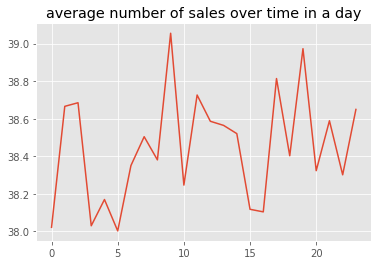

In [29]:
plt.plot(hours, trades_cl.groupby('hour').agg({'price':'count'})/365)
plt.style.use('ggplot')
plt.title("average number of sales over time in a day")
plt.show()

=>Le libraire vends en moyenne entre 38 et 40 livres par heure sur la base des données annuelles

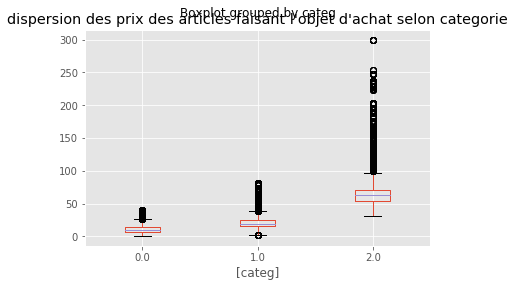

In [30]:
#analyse bivariée var cat / var quant
trades_cl[['sex', 'categ', 'price']].boxplot(column = 'price', by=['categ'])
plt.title("dispersion des prix des articles faisant l'objet d'achat selon categorie")
plt.savefig("prix_categ.png")
plt.show()

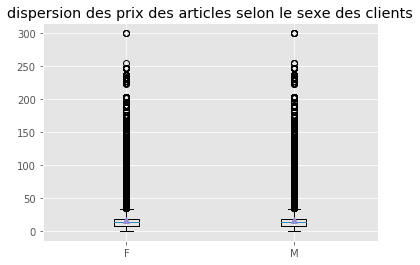

In [31]:
#On fait des boxplot pour comparer la dispersion des prix des articles achetés
box_f = trades_cl.loc[trades_cl['sex'] == 'f', 'price'].dropna().values
box_m = trades_cl.loc[trades_cl['sex'] == 'm', 'price'].dropna().values
plt.boxplot([box_f, box_m], labels=['F', 'M'],showmeans=True)
plt.title('dispersion des prix des articles selon le sexe des clients')
#plt.savefig("prix_sexe.png")
plt.show()

=> On observe pas de différence de dispersion des sommes dépensées par article selon le sexe et ***énormément*** d'outliers

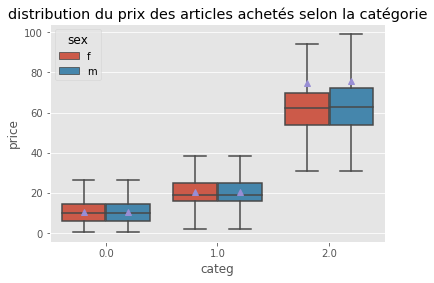

In [32]:
#Ici on choisit d'exclure les outliers que l'on a déjà représenté dans le graphique précédent
sns.boxplot(x = 'categ', y = 'price', hue = 'sex', data = trades_cl[['client_id', 'categ', 'sex', 'price']],\
            width = 0.8,  showfliers=False, showmeans=True)
plt.title('distribution du prix des articles achetés selon la catégorie')
#plt.savefig("prix_categ_sex.png")
plt.show()

In [33]:
#ANOVA : relation entre categorie de produit et prix
f_va, p_va = f_oneway(trades_cl.categ, trades_cl.price)
print(f_va, p_va)

297344.8074441619 0.0


=> Les prix dépendent de la catégorie de produit (p-value = 0)

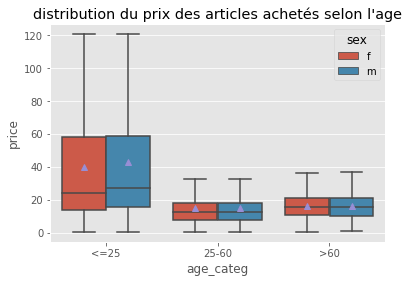

In [34]:
#On ne represente pas les outliers car ils sont bcp trop nombreux
sns.boxplot(x = 'age_categ', y = 'price', hue = 'sex', data = trades_cl[['sex', 'age_categ', 'price']],\
            order=["<=25","25-60",">60"],width = 0.8, showfliers=False, showmeans=True)
plt.title("distribution du prix des articles achetés selon l'age")
#plt.savefig("distribution du prix des articles achetés selon l'age.png")
plt.show()

#### => Il n'y a vraiment pas de différence de prix des article achetés selon le sexe, même en incluant une analyse des différentes catégories
=> Il y a une différence de prix des articles achetés selon la tranche d'âge mais attention la tranche 25-60 comporte beaucoup plus d'individus  

##### => On a des transactions dont le prix est >= 200. Elles n'ont pas l'air suspectes

In [35]:
products.loc[products['price'] >= 200 ].head()

,id_prod,price,categ
10,2_228,225.17,2
95,2_128,201.74,2
394,2_158,247.22,2
724,2_76,254.44,2
786,2_40,228.11,2


In [36]:
products.loc[products['price'] >= 200, 'id_prod'].unique(), len(products.loc[products['price'] >= 200, 'id_prod'].unique())

(array(['2_228', '2_128', '2_158', '2_76', '2_40', '2_2', '2_211', '2_167',
        '2_87', '2_4', '2_125', '2_3', '2_166', '2_30', '2_11'],
       dtype=object),
 15)

**=> On a 15 produits (livres) dont le prix est >= 200 €**

### Courbe Lorenz

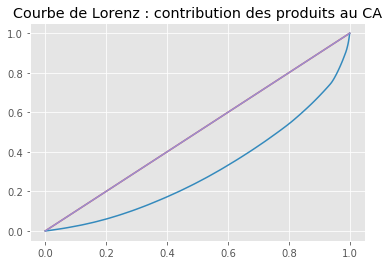

0.39210252514328736

In [37]:
# On definit la variable de l'axe des ordonnées
price_var = trades_cl['price'].copy().sort_values( ascending=True)
price_var.dropna(inplace = True)
pr = price_var.values
n = len(pr)

lorenz = np.cumsum(np.sort(pr)) / pr.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

#On definit la première bissectrice
plt.plot([0,1], [0,1])

# On definit la var de l'axe des abcisses
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis, lorenz, drawstyle='steps-post')

#tracé bissectrice
plt.plot([0,1], [0,1])
#plt.savefig("lorenz_gini.png")
plt.title('Courbe de Lorenz : contribution des produits au CA')
plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et la courbe de Lorenz
gini = 2*S
gini

=> Les ventes de produits ayant des prix élevés concentrent une grande part de la contribution au CA)

## MISSION 3

In [38]:
len(trades_cl.client_id.unique()), len(trades_cl.session_id.unique()), 

(8600, 169194)

In [39]:
# total d'achats annuels par clients
total_pur = trades_cl.groupby('client_id').agg({'price':'sum'})
total_pur

,price
client_id,
c_1,300.65
c_10,586.18
c_100,222.87
c_1000,980.02
c_1001,1102.45
...,...
c_995,119.08
c_996,739.60
c_997,572.89


In [40]:
# nb d'articles par paniers et 'Top'
basket_size = trades_cl.groupby(by = ['client_id', 'session_id']).agg({'price':'count'})
basket_size.head()#.sort_values(by='price', ascending=False).head()

price
client_id session_id       
c_1       s_105105        1
          s_114737        5
          s_120172        2
          s_134971        1
          s_136532        1

In [41]:
#les totaux par paniers individuels
basket_total = trades_cl.groupby( by = ['client_id', 'session_id']).agg({'price':'sum'})
#plus cher paniers individuels
basket_total.sort_values(by='price', ascending=False).head()

,,price
client_id,session_id,
c_8345,s_123227,539.23
c_3241,s_83158,535.17
c_667,s_150439,496.22
c_4658,s_170478,476.19
c_4958,s_165683,473.98


In [42]:
# On fait une boucle 'for' pour extraire le nombre de sessions par clients
index_c = trades_cl.client_id.unique()
#On créée un dictionnaire pour correspondre les clients et leur nombre de sessions
dict_df = {"client_id":[],
          "basket_n":[]}
for i in index_c:
    dict_df["client_id"].append(i)
    dict_df["basket_n"].append(len(basket_total.loc[i]))

In [43]:
#on créée un df qui donne le nombre de paniers par clients
df_basket_n = pd.DataFrame(dict_df)
df_basket_n.head()

,client_id,basket_n
0,c_4450,44
1,c_277,7
2,c_4270,24
3,c_4597,3
4,c_1242,11


In [44]:
df_basket_n2 = df_basket_n.set_index('client_id', drop=True, append=False, inplace=False, verify_integrity=False)
df_basket_n2.head()

,basket_n
client_id,
c_4450,44
c_277,7
c_4270,24
c_4597,3
c_1242,11


### On calcule le panier moyen par client

In [45]:
#join gauche sur l'index commun entre les 2 DF
basket_avg = total_pur.join(df_basket_n2)
basket_avg['mean_b'] = basket_avg['price']/basket_avg['basket_n'] 
#top des paniers moyens de clients les plus cher
basket_avg.head()#.sort_values(by='mean_b', ascending=False).head()

,price,basket_n,mean_b
client_id,,,
c_1,300.65,15,20.043333
c_10,586.18,16,36.636250
c_100,222.87,3,74.290000
c_1000,980.02,42,23.333810
c_1001,1102.45,24,45.935417


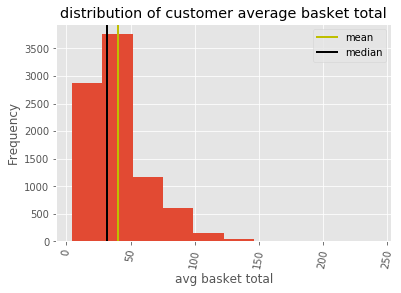

In [46]:
#On plot la distribution du panier moyen annuel des clients
plt.hist(basket_avg.mean_b)
plt.xlabel('avg basket total')
plt.ylabel('Frequency')
plt.xticks(rotation=80)
plt.axvline(x=basket_avg.mean_b.mean(), label='mean', linewidth=2, color = 'y')
plt.axvline(x=st.median(basket_avg.mean_b), label='median', linewidth=2, color = 'black')
plt.title("distribution of customer average basket total")
#plt.savefig("average_baskets.png")
plt.legend()

In [47]:
basket_avg.basket_n.unique()

array([  15,   16,    3,   42,   24,   11,   21,   18,   63,    2,    5,
          4,   10,   40,   45,   38,   34,    6,    8,    9,   17,   60,
         12,   26,   55,   47,   13,   61,    7,   31,   32,   39,   14,
         23,   49,   57,   30,   33,   62,   25,   27,   48,   64,   67,
         19,   41,   44,    1,   43,   20,   35,   22,   46,   28,   29,
         36,   50,   53,   59,   69,   37,   71,   51,   58,   66,   70,
         54, 5501,   74,   75,   65,   52,   56,   68,   72, 2711,   73,
       1888,   77, 1286,   84,   76,   79])

## Paniers

Y a-t-il une corrélation entre l'âge des clients et :

    Le montant total des achats ;
    La fréquence d’achat (ie. nombre d'achats par mois par exemple) ;
    La taille du panier moyen (en nombre d’articles) ;
    Les catégories de produits achetés.


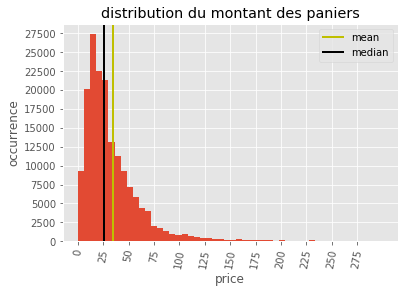

In [48]:
plt.hist(basket_total.price, bins = 50, range = [0, 300])

plt.yticks(np.arange(0, 29000, step=2500))
plt.xticks(np.arange(0, 300, step=25))
plt.xlabel('price')
plt.ylabel('occurrence')
plt.xticks(rotation=80)
plt.axvline(x=basket_total.price.mean(), label='mean', linewidth=2, color = 'y')
plt.axvline(x=st.median(basket_total.price), label='median', linewidth=2, color = 'black')
plt.title("distribution du montant des paniers")
#plt.savefig("hist_basket_totals.png")
plt.legend()

In [49]:
#Nota : ici on a des paniers moyens (globalement)
basket_total.price.skew(), basket_total.price.mean(), st.mode(basket_total.price), st.median(basket_total.price)

(3.348249192297504, 34.267091314429535, 15.99, 25.57)

***=> le skew (>>0.5) indique que les individus se concentrent vers la gauche et la queue de la courbe va vers la droite***
=> On Rq aussi que la courbe a une silhouette similaire à la courbe de l'histogramme des paniers moyens des clients
=> On montre qu'il y a plus de paniers dont le montant est inférieur à la médiane

### Analyse bivariée

## ***Y a-t-il une corrélation entre l'âge des clients et : Le montant total des achats***

#### Par 'montant total des achats' on va entendre : montant total des paniers

In [50]:
basket_total = trades_cl.groupby( by = ['client_id', 'session_id', 'age']).agg({'price':'sum'})
basket_total_r = basket_total.reset_index()[['age', 'price']]

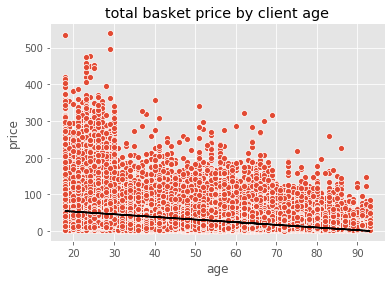

In [51]:
basket_total_r
sns.scatterplot(basket_total_r.age, basket_total_r.price);

model = LinearRegression()

age = np.array(basket_total_r.age).reshape(-1, 1)
price = np.array(basket_total_r.price).reshape(-1, 1)
# il faut que len des variables soit égal -> OK
len(age), len(price)
#On donne les données au modele
model.fit(age, price)
#graphiques
plt.plot(age, model.predict(age), color = "black")
plt.title('total basket price by client age')
#plt.savefig("basket_total_age.png")
plt.show()

### Ce score est très faible il indique que seul 11% de la variabilité du prix des paniers s'explique par l'age (le coef de corrélation est négatif graphiquement) => donc NON pas de corrélation entre age et prix total du panier

In [52]:
#calcul R square et coef de corrélation :
r2_score(basket_total_r.price, model.predict(age)), -math.sqrt(r2_score(basket_total_r.price, model.predict(age)))

(0.11334581883967165, -0.3366687078415095)

## ***Y a-t-il une corrélation entre l'âge des clients et : La fréquence d’achat (ie. nombre d'achats par mois par exemple)***

In [53]:
cor_age_freq = trades_cl[['client_id', 'age']].groupby(by='client_id').agg({'age':'unique'})

In [54]:
#La fonction agg 'unique' sort un array, il faut convertir
df_cor = cor_age_freq.join(df_basket_n2).copy()
df_cor['age'] = df_cor['age'].astype(int)
df_cor

,age,basket_n
client_id,,
c_1,67,15
c_10,66,16
c_100,30,3
c_1000,56,42
c_1001,40,24
...,...,...
c_995,67,5
c_996,52,36
c_997,28,10


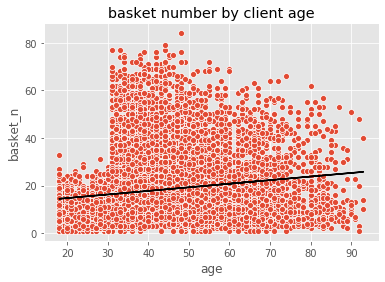

In [55]:
df_cor = cor_age_freq.join(df_basket_n2).copy()
#on exclut les outliers du graphique
df_cor = df_cor.loc[ df_cor['basket_n'] < 1000]
df_cor['age'] = df_cor['age'].astype(int)
sns.scatterplot(df_cor.age, df_cor.basket_n)
plt.title('basket number by client age')

#regression linéaire
age_cor = np.array(df_cor.age).reshape(-1, 1)
basketn_cor = np.array(df_cor.basket_n).reshape(-1, 1)
model.fit(age_cor, basketn_cor)
#droite de regression
plt.plot(age_cor, model.predict(age_cor), color = "black")
#plt.savefig("basket_frequency_age.png")
plt.show()

In [56]:
#calcul R square et coef de corrélation :
r2_score(df_cor['age'], model.predict(age_cor))

-1.9741822167142438

### => On trouve un R2 negatif donc la droite de regression a une somme des moindre carrés > à la somme des moindre carrés par rapport la droite égale au nombre moyen de paniers => pas de corrélation
Par contre on voit graphiquement que si on segmente les tranches d'âge ainisi : 0-30, 30-60, 60-100
On pourrait voir des regression linéaires partielles qui décrivent une corrélation

In [57]:
#analyse plus adaptée
age_categ_freq = trades_cl[['client_id', 'age_categ']].groupby(by='client_id').agg({'age_categ':'unique'})
#age_categ_freq
cor_categ = age_categ_freq.join(df_basket_n2).copy()
cor_categ['age_categ'] = cor_categ['age_categ'].astype(str)
cor_categ.head()

,age_categ,basket_n
client_id,,
c_1,['>60'],15
c_10,['>60'],16
c_100,['25-60'],3
c_1000,['25-60'],42
c_1001,['25-60'],24


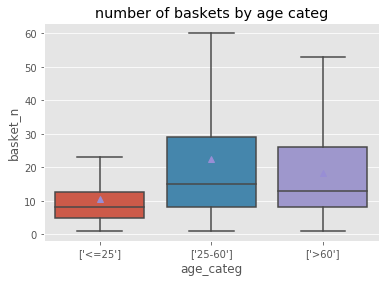

In [58]:
#On ne represente pas les outliers car ils sont bcp trop nombreux
sns.boxplot(x = 'age_categ', y = 'basket_n', data = cor_categ.reset_index(),\
            order=["['<=25']","['25-60']","['>60']"],width = 0.8, showfliers=False, showmeans=True)
plt.title("number of baskets by age categ")
#plt.savefig("baskets_age_categ.png")
plt.show()

=> cela reflète la faible fréquence d'achats chez les jeunes, que l'on lisait graphiquement sur le nuage de points

## ***Y a-t-il une corrélation entre l'âge des clients et : La taille du panier moyen (en nombre d’articles)***

In [59]:
#on va utiliser la var qu'on avait crée en amont
#basket_size
df_corre = cor_age_freq.join(basket_size).copy()
df_corre['age'] = df_corre['age'].astype(int)
df_corre.head()

age  price
client_id session_id            
c_1       s_105105     67      1
          s_114737     67      5
          s_120172     67      2
          s_134971     67      1
          s_136532     67      1

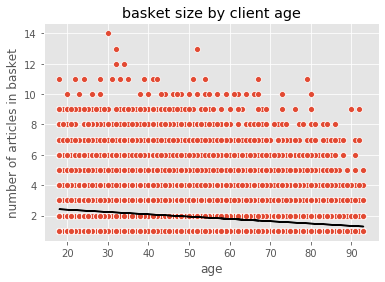

In [60]:
#distribution bivariée
sns.scatterplot(df_corre.age, df_corre.price)
plt.title('basket number by client age')

#regression linéaire
age_corre = np.array(df_corre.age).reshape(-1, 1)
basket_corre = np.array(df_corre.price).reshape(-1, 1)
model.fit(age_corre, basket_corre)
#droite de regression
plt.plot(age_corre, model.predict(age_corre), color = "black")
plt.title('basket size by client age')
plt.ylabel('number of articles in basket')
#plt.savefig("basket_size_age.png")
plt.show()

In [61]:
#calcul R square et coef de corrélation :
r2_score(df_corre.price, model.predict(age_corre)), math.sqrt(r2_score(df_corre.price, model.predict(age_corre)))

(0.031566468185664665, 0.17766954771615948)

### Là encore le nombre d'article par panier n'est pas corrélé à l'âge : la variable âge n'explique que 3% de la variabilité du nombre d'articles par paniers par rapport au nombre moyen par panier

## Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

In [62]:
#on fait une aggrégation 'count' pour raisonner en termes d'achats sans égard pour les prix
cont_df = trades_cl[['sex','categ','price']].groupby( by = ['sex', 'categ']).agg({'price':'count'}).unstack('sex')
cont_df

price        
sex         f       m
categ                
0.0    103846  105683
1.0     55469   54266
2.0      8260    9292

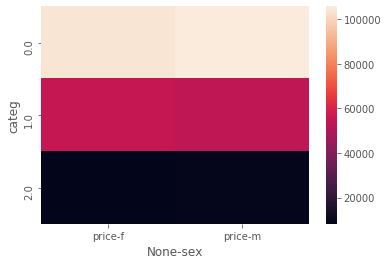

In [63]:
#On analyse la corrélation entre le sexe et la la catégorie des articles achetés
sns.heatmap(cont_df)
#plt.savefig("cont_table.png")

On a 2 degrés de libertés (3-1)*(2-1)
conditions test Chi-2 : echantillon pas trop petit et pourcentages pas trop proches de 100%

In [64]:
chi2_contingency(cont_df)

(81.73335807676145,
 1.7857752515034613e-18,
 2,
 array([[104246.30117037, 105282.69882963],
        [ 54596.10774132,  55138.89225868],
        [  8732.59108831,   8819.40891169]]))

Chi2>>5.99 donc il faudrait rejeter H0; p-value : La proba d'avoir un echantillon aussi extreme ou plus encore que celui que nous avons est infime dans l'hypothèse H0, cela n'est pas cohérent car graphiquement le choix des categories est indépendant du sexe... En outre les valeurs attendues sont très similaires à celles de l'échantillon

In [65]:
#on fait une Anova : on considère que seul le sexe est catégoriel
idx = pd.IndexSlice
#on slice le multi index
female = cont_df.loc[:, idx[:,'f']]
male = cont_df.loc[:, idx[:,'m']]
f_val, p_val = f_oneway(female, male)
print(f_val, p_val)

[0.00020067] [0.98937617]


p~0.9>>0.05 donc les 2 groupes, (sous groupés en catégories) sont indépendants (cela saute aux yeux vu la heatmap)